# Read in Clean Data

This notebook reads in the data cleaned during part one of EDA and creates several models in an attempt to identify a model that balances accurate predictions with overall interpretability.


In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest

#sklearn.set_config(display='diagram')
from sklearn import set_config
set_config(display='diagram')

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [2]:
# https://stackoverflow.com/questions/33952142/prevent-pandas-from-interpreting-na-as-nan-in-a-string
train = pd.read_csv('../02_DATA/ames_train_clean.csv', keep_default_na=False)
test = pd.read_csv('../02_DATA/ames_test_clean.csv', keep_default_na=False)

In [3]:
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,House_Age,Remodel_Age
0,109,533352170,60,RL,68.0,13517,1,NA,3,Lvl,...,0,0,NA,0,3,2010,WD,130500,34,5
1,544,531379050,60,RL,43.0,11492,1,NA,3,Lvl,...,0,0,NA,0,4,2009,WD,220000,13,12
2,153,535304180,20,RL,68.0,7922,1,NA,4,Lvl,...,0,0,NA,0,1,2010,WD,109000,57,3
3,318,916386060,60,RL,73.0,9802,1,NA,4,Lvl,...,0,0,NA,0,4,2010,WD,174000,4,3
4,255,906425045,50,RL,82.0,14235,1,NA,3,Lvl,...,0,0,NA,0,3,2010,WD,138500,110,17


In [4]:
#train.drop(columns=['Id', 'PID', 'MS Zoning', 'Alley', 'Land Contour', 'Lot Config', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
#                   'Year Built', 'Year Remod/Add', ''])
test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,House_Age,Remodel_Age
0,2658,902301120,190,RM,69.0,9142,1,Grvl,4,Lvl,...,0,0,0,NA,0,4,2006,WD,96,56
1,2718,905108090,90,RL,68.0,9662,1,NA,3,Lvl,...,0,0,0,NA,0,8,2006,WD,29,29
2,2414,528218130,60,RL,58.0,17104,1,NA,3,Lvl,...,0,0,0,NA,0,9,2006,New,0,0
3,1989,902207150,30,RM,60.0,8520,1,NA,4,Lvl,...,0,0,0,NA,0,7,2007,WD,84,1
4,625,535105100,20,RL,68.0,9500,1,NA,3,Lvl,...,0,0,0,NA,0,7,2009,WD,46,46


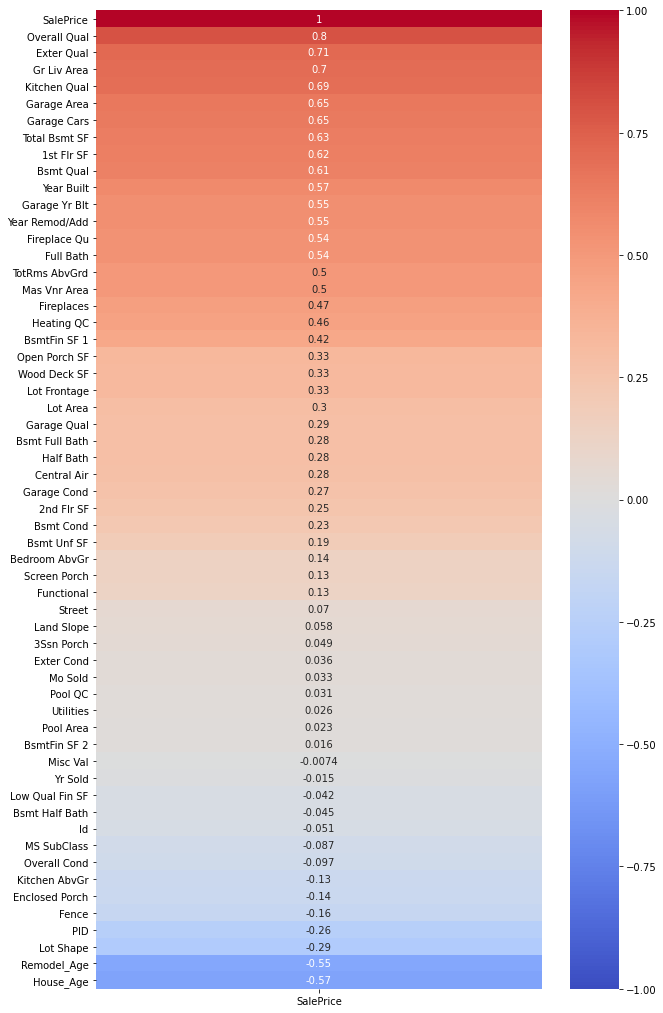

In [5]:
plt.figure(figsize=(10, 18))
sns.heatmap(train.corr()[['SalePrice']].sort_values(by=['SalePrice'],ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

## Null Model (Baseline)
In order to meaningfully compare the performance of our models, we must establish a baseline. Since we are attempting to predict sale price, and because our data were not normally distributed our baseline prediction will be the median of all sale price values in the training data set. 

We will evaluate the performance of our null model first. 

In [6]:
baseline = train['SalePrice'].median()
y_baseline = np.full_like(train['SalePrice'], baseline)
y_baseline

array([162500, 162500, 162500, ..., 162500, 162500, 162500])

In [7]:
rmse = round(mean_squared_error(train['SalePrice'], y_baseline, squared=False), 2)

print(f'Baseline Prediction: {round(baseline, 2)}, RMSE: {rmse}')

Baseline Prediction: 162500.0, RMSE: 81478.35


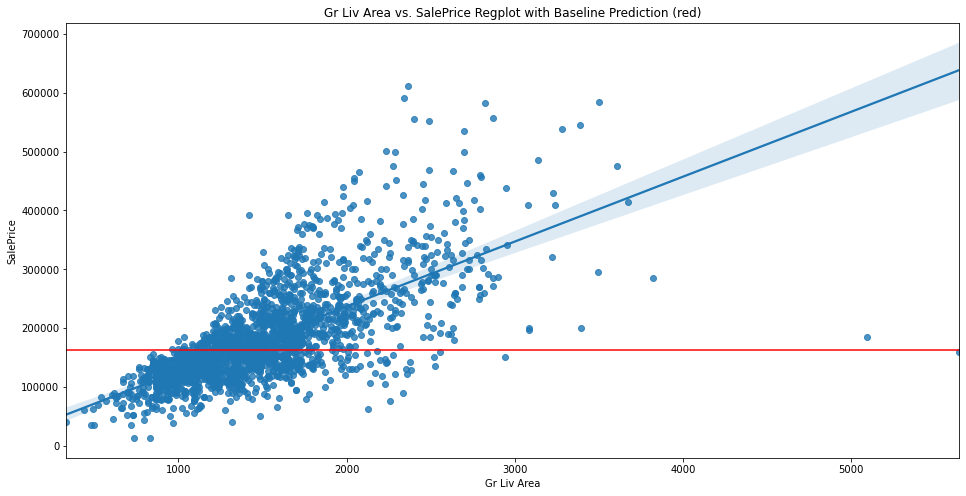

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.regplot(data=train, x='Gr Liv Area', y='SalePrice', ax=ax)
ax.set_title('Gr Liv Area vs. SalePrice Regplot with Baseline Prediction (red)')
plt.axhline(baseline, color='red');

### Null Model Summary

Our baseline prediction (the median SalePrice value) of 162500.0 had an RMSE of 81478.35. 

The following models attempt to improve on that RMSE score. 

# Model #1
## Simple Linear Regression (One Variable)

Based on our correlation matrix, `Overall Qual` was the variable most highly positively correlated with SalePrice. However, `Overall Qual` is very clearly related to other variables, introducing some multicolinearity. Our first model then will be a simple linear regression using one variable, `Gr Liv Area`, to see how much of the variance in Sale Price can be attributed to that variable alone. 

Based on exploratory analysis, I believe that this simple model might be capable of generating decent predictions. 

In [10]:
# set X and y
X = train[['Gr Liv Area']]
y = train['SalePrice']

# TTS
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#instantiate and fit sklearn LinearRegression 
lr =  LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [11]:
# print out the R2 and RMSE
print(f'TRAIN - R2: {round(lr.score(X_train, y_train), 2)}, RMSE: {round(mean_squared_error(y_train, lr.predict(X_train), squared=False), 2)}')
print(f'TEST - R2: {round(lr.score(X_test, y_test), 2)}, RMSE: {round(mean_squared_error(y_test, lr.predict(X_test), squared=False), 2)}')

TRAIN - R2: 0.48, RMSE: 57440.75
TEST - R2: 0.51, RMSE: 54942.3


In [12]:
# generate preds
preds = lr.predict(X_test)
resids = y_test - preds

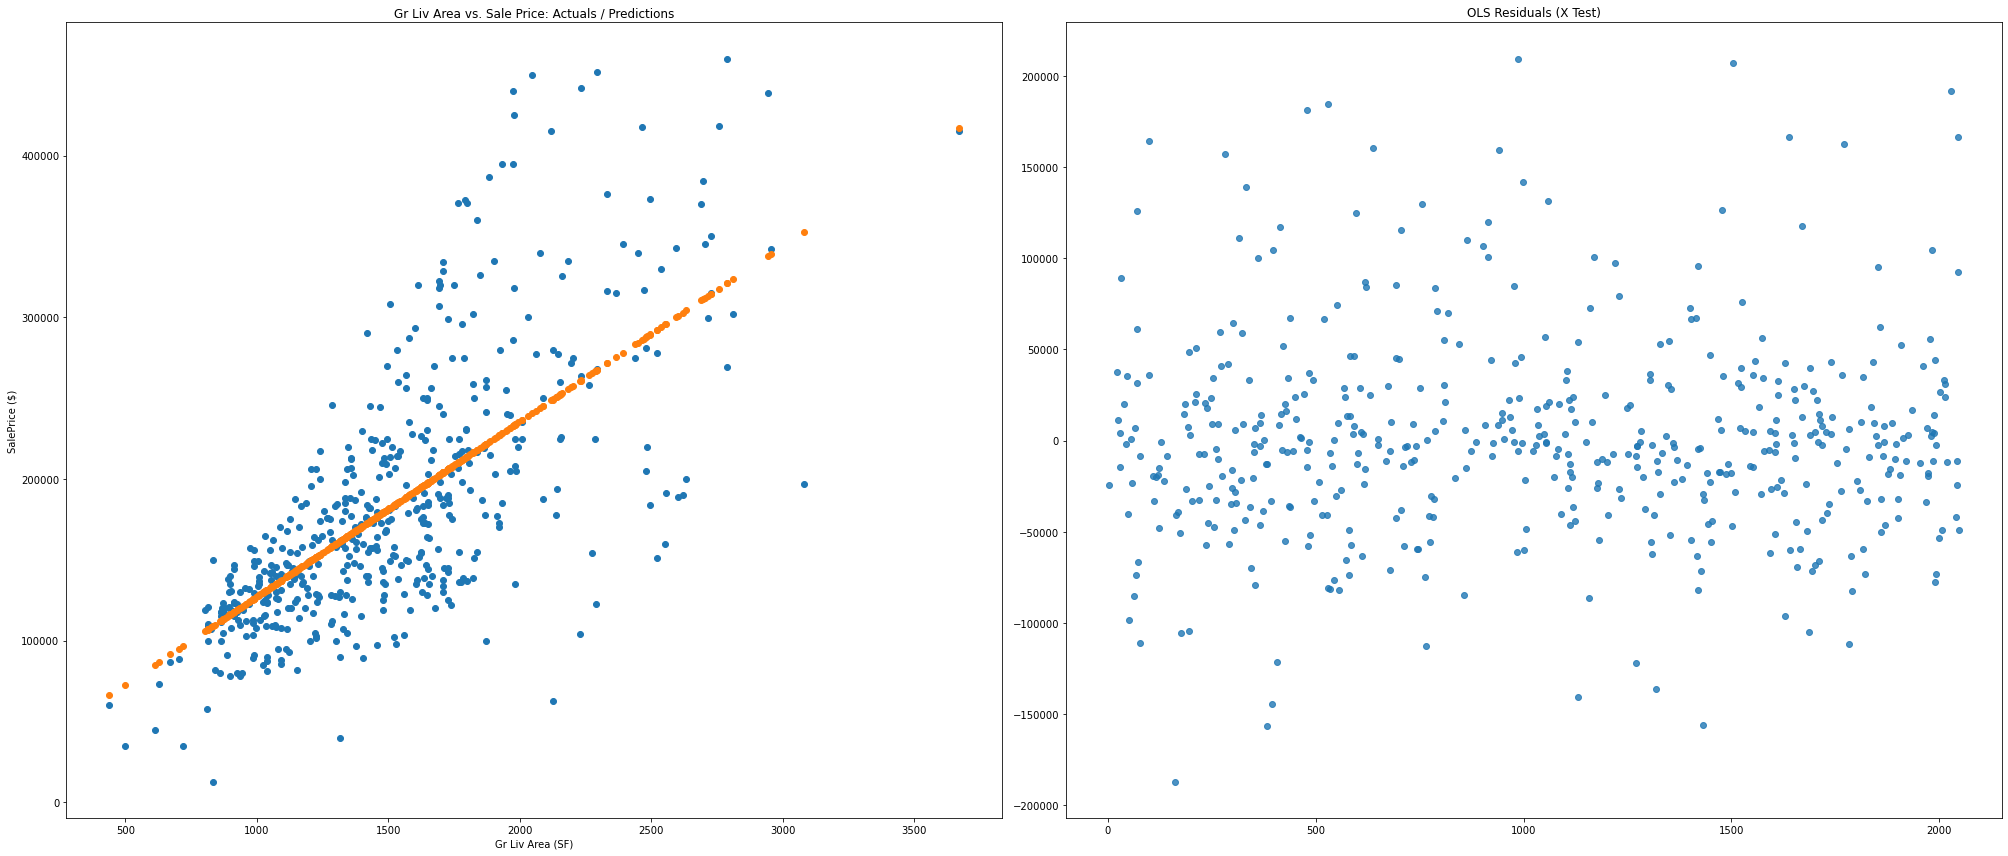

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(28, 12))
# plotting X_test, y_test
ax[0].set_title("Gr Liv Area vs. Sale Price: Actuals / Predictions")
ax[0].set_xlabel('Gr Liv Area (SF)')
ax[0].set_ylabel('SalePrice ($)')
ax[0].scatter(X_test, y_test)
ax[0].scatter(X_test, preds)

# plotting the residuals
ax[1].set_title("OLS Residuals (X Test)")
ax[1].plot(resids, 'o', alpha=0.80)

plt.tight_layout();

In [15]:
coef_val = round(lr.coef_[0], 2)
int_val = round(lr.intercept_, 2)

print(f'Line: y = {coef_val}x + {int_val}')

Line: y = 108.43x + 18712.68


**Model 1 Summary:** 

A simple, single variable linear regression using `Gr Liv Area` as the dependent variable outperforms our Null Model significantly (RMSE of 54942.3 vs Null RMSE of 81478.35). We can look at the equation of our line to identify that for every additional square foot of `Gr Liv Area`, the home's `SalePrice` increases by ***$108.43*** 


51% of the variance in `SalePrice` can be explained by variations in `Gr Liv Area` (compared to a model with no predictors).

This model actually performed a little better on the unseen test data than on the training set. The difference in R2 score between the training and testing datasets was not significant enough to raise concerns of overfitting. 

---


# Model #2
### Testing Multiple Regression Models with 3 Dependent Variables: `Overall Qual`, `Gr Liv Area` and `Neighborhood`

While our simple linear regression performed better than simply taking the median of SalePrice, with 49% of the variance in `SalePrice` unexplained by `Gr Liv Area` alone, there is clearly room for improvement. In our second modeling exercise, we will incorporate three variables into our X and search over a few different regression models (using their default parameters) to see how they compare. 

After identifying the best performing model, we will tune the parameters using GridSearchCV to see if the R2 and RMSE can be further improved upon. 


In [17]:
# set Model 2 X and Y
X = train[['Overall Qual', 'Gr Liv Area', 'Neighborhood']]
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
# create a function that returns the scores and RMSE
def model_eval(df, x_vars, y, models_list):
    '''
        Summary: 
        Function accepts a dataframe, a list of x variables, the y_variable, and a list of the models for evaluation.
        Function then sets X/y, TTS, instantiates and fits models in list and returns scores
        
        Returns:
        No objects, prints scores/RMSE for each model evaluated
    
    '''
    X = df[x_vars]
    y = df[y]
    
    # TTS
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # if we pass categorical vars, we'll want to OHE
    ohe = OneHotEncoder(sparse=False, drop='if_binary', handle_unknown='ignore')
    
    # we'll also want to transform the columns for interpretability, but we only want to pass categorical vars
    # select only the objects to be sent to the ohe
    cat_vars = X.select_dtypes(include=[object])
    
    ct = make_column_transformer(
    (ohe, cat_vars.columns),
    remainder='passthrough',
    verbose_feature_names_out=False
    )
    
#     train_r2 = []
#     test_r2 = []
#     train_rmse = []
#     test_rmse = []
    
    for model in models_list:
        pipe = make_pipeline(ct, model)
        pipe.fit(X_train, y_train)
        
        train_r2 = round(pipe.score(X_train, y_train), 4)
        test_r2 = round(pipe.score(X_test, y_test), 4)
        
        train_rmse = round(mean_squared_error(y_train, pipe.predict(X_train), squared=False), 3)
        test_rmse = round(mean_squared_error(y_test, pipe.predict(X_test), squared=False), 3)
        
        print(f'{model} - Train/Test R2: {train_r2} / {test_r2}, RMSE: {train_rmse} / {test_rmse}')

    return None    
        
    

In [19]:
x_vars = ['Overall Qual', 'Gr Liv Area', 'Neighborhood']
lr = LinearRegression()
lasso = Lasso(max_iter=2_000) #upped the max iter from default bc of convergence warning
ridge = Ridge()

models = [lr, lasso, ridge]

In [20]:
model_eval(train, ['Overall Qual', 'Gr Liv Area', 'Neighborhood'], 'SalePrice', models)

LinearRegression() - Train/Test R2: 0.7981 / 0.7989, RMSE: 35736.425 / 35135.319
Lasso(max_iter=2000) - Train/Test R2: 0.7981 / 0.799, RMSE: 35736.49 / 35132.649
Ridge() - Train/Test R2: 0.7977 / 0.8001, RMSE: 35766.008 / 35032.281


### Model 2 Summary

These models performed nearly identically, with the Ridge Regression just barely outperforming the Linear Regression and the Lasso based on Test R2 and RMSE. 

Our next "model" will simple be a hypertuning of some of the parameters of the Ridge Model and interpreting those results. 

# Model #2.5

Here we refine the parameters of a Ridge Regression Model. GridSearchCV was used to search over and find the best parameters.

In [21]:
# set X, y
X = train[['Overall Qual', 'Gr Liv Area', 'Neighborhood']]
y = train['SalePrice']

# TTS
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#instantiate Ridge Regression
ridge = Ridge()

# create OHE instance
ohe = OneHotEncoder(sparse=False, drop='if_binary', handle_unknown='ignore')

# create column transformer instance
ct = make_column_transformer(
    (ohe, ['Neighborhood']),
    remainder='passthrough',
    verbose_feature_names_out=False
)

# ridge params: put ridge__ before all params
# {'alpha': 1.0,
#  'copy_X': True,
#  'fit_intercept': True,
#  'max_iter': None,
#  'normalize': 'deprecated',
#  'positive': False,
#  'random_state': None,
#  'solver': 'auto',
#  'tol': 0.001}

# create pipeline
pipe = make_pipeline(ct, Ridge())
#pipe.get_params()
ridge_params = {
    'ridge__alpha': [0.5, 1, 10, 25, 50, 100],
    #'ridge__fit_intercept': [True, False],
    'ridge__copy_X': [True, False],
    'ridge__max_iter': [500, 1_000, 2_000, 5_000, 10_000],
    'ridge__solver': ['svd', 'cholesky', 'lsqr', 'saga']
}

In [22]:
#instantiate & fit GridSearchCV
gs = GridSearchCV(estimator=pipe, param_grid=ridge_params, n_jobs=-1)

gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['Neighborhood'])],
                                                          verbose_feature_names_out=False)),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.5, 1, 10, 25, 50, 100],
                         'ridge__copy_X': [True, False],
                         'ridge__max_iter': [500, 1000, 2000, 5000, 10000],
                         'ridge__solver': ['svd', 'cholesky', 'lsqr', 'saga']})

In [23]:
# after trying multiple parameters, I was not able to achieve above the default score
print(gs.score(X_test, y_test)) # 8001212061940923
print(gs.best_params_)

0.8001212061940923
{'ridge__alpha': 1, 'ridge__copy_X': True, 'ridge__max_iter': 500, 'ridge__solver': 'cholesky'}


In [24]:
preds = gs.predict(X_test)
rmse = mean_squared_error(y_test, preds, squared=False)
rmse

35032.281356385996

In [27]:
print(f'Train R2: {gs.score(X_train, y_train)}')
print(f'Test R2: {gs.score(X_test, y_test)}')

print(f'Train RMSE: {mean_squared_error(y_train, gs.predict(X_train), squared=False)}')
print(f'Train RMSE: {mean_squared_error(y_test, gs.predict(X_test), squared=False)}')

Train R2: 0.7977384450651306
Test R2: 0.8001212061940923
Train RMSE: 35766.00753897431
Train RMSE: 35032.281356385996


In [ ]:
coefs = gs.best_estimator_.named_steps['ridge'].coef_
cols = gs.best_estimator_.named_steps['columntransformer'].get_feature_names_out()

ridge_coefs = pd.DataFrame({'Features': cols, 'Coef': coefs})
ridge_coefs.sort_values('Coef', ascending=False, inplace=True)
ridge_coefs

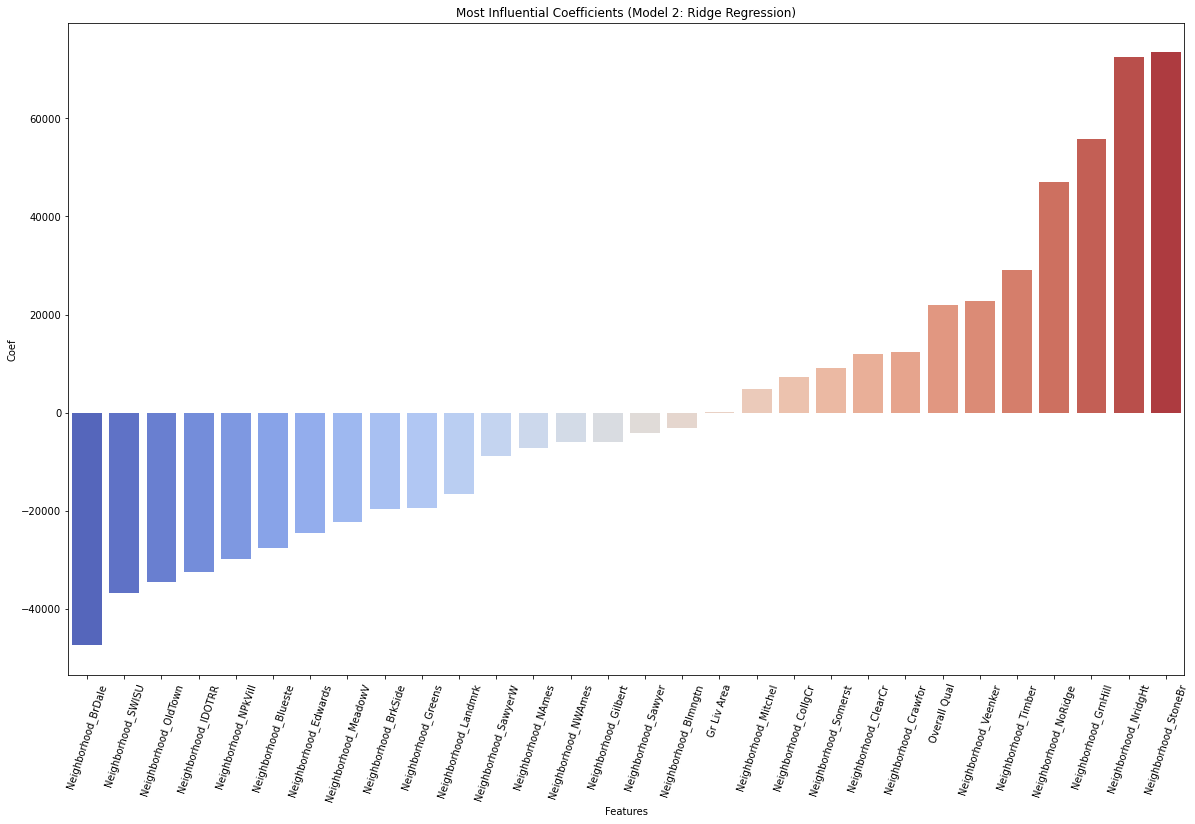

In [43]:
#plt.style.use('seaborn')
plt.subplots(figsize=(20, 12))
sns.barplot(data = ridge_coefs.sort_values('Coef'), x='Features', y='Coef', palette='coolwarm')
plt.title('Most Influential Coefficients (Model 2: Ridge Regression)')
plt.xticks(rotation=72);

### Model 2/2.5 Summary

While the interprability of the Ridge Regression model doesn't lend itself to as direct of an understanding as our first univariate model (where each foot of living area had a direct increase in sale price), what this *does* show us is that while the neighborhood that a home is located in often has a more significant effect on SalePrice than `Overall Qual` and `Gr Liv Area` alone. Two Neighborhoods in particular, `Stone Briar` and `Northridge Heights`  have a very strong positive relationship with `SalePrice`, and the value of the coefficients for each of those neighborhoods in our resulting regression equation is more than double the value of the `Overall Qual` coef. 

Interestingly, when investigated in combination with `Overall Qual` and `Neighborhood`, `Gr Liv Area` doesn't appear to have much influence at all, suggesting that quality of the house and location are perhaps the most important factors in determining a home's Sale Price in Ames, Iowa.

Tuning the parameters on this model didn't result in any increase in R2 score or RMSE from the default parameters. However, this Ridge model is an improvement over our first univariate Linear Regression model. Approximately 80% of the variance in `SalePrice` can be attributed to `Neighborhood`, `Overall Qual` and `Gr Liv Area` - our first model using only `Gr Liv Area` only accounted for 51% of the difference in `SalePrice`. 

A more complex model will likely boost R2 score and lower RMSE, but might also risks obfuscating any meaning that might be derived from the results. 

---

# Model #3 
## Pipeline with StandardScaler, SelectKBest, Lasso, GridSearchCV 

Use almost all the variables this time, dropping only a small handful that had tiny correlations in our heatmap

In [60]:
#train['Misc Feature'].value_counts()

In [78]:
X = train.drop(columns=['PID', 'Id', 'Yr Sold', 'Misc Val', 'BsmtFin SF 2' ,'SalePrice', 'Misc Feature'])
# X = test.drop(columns=['PID', 'Id', 'Yr Sold', 'Misc Val', 'BsmtFin SF 2' , 'Misc Feature']) #test set for Kaggle sub
y  = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [79]:
ohe = OneHotEncoder(sparse=False, drop='if_binary', handle_unknown='ignore')

ct = make_column_transformer(
    (ohe, make_column_selector(dtype_include=object)),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [80]:
# make pipeline with column transformer (smart_encoder), Standard Scaler & Lasso
pipe = make_pipeline(ct, StandardScaler(), SelectKBest(k=150), Lasso())

# 'selectkbest__k':
params = {'standardscaler__with_mean': [True, False], 'standardscaler__with_std': [True, False], 'lasso__alpha': [0.01, 0.5, 1, 5, 10] }

gs = GridSearchCV(estimator=pipe, param_grid=params)

gs.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  0  28  60  92 124 125 149 171 183] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.852e+11, tolerance: 7.781e+08
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklea

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7ff6860f1ac0>)],
                                                          verbose_feature_names_out=False)),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest', SelectKBest(k=150)),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': [0.01, 0.5, 1, 5, 10],
                         'standardscaler__with_mean': [True, False],
                         'standardscaler__with_std': [True, False]})

In [81]:
print(f'Train R2: {gs.score(X_train, y_train)}')
print(f'Test R2: {gs.score(X_test, y_test)}')

Train R2: 0.9074685282488123
Test R2: 0.8954206631345122


/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [82]:
print(f'Train RMSE: {mean_squared_error(y_train, gs.predict(X_train), squared=False)}')
print(f'Train RMSE: {mean_squared_error(y_test, gs.predict(X_test), squared=False)}')

Train RMSE: 24191.262156006593
Train RMSE: 25340.08118837845


/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [83]:
gs.best_params_

{'lasso__alpha': 10,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': False}

In [84]:
gs.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff6860f13a0>)],
                                   verbose_feature_names_out=False)),
                ('standardscaler', StandardScaler(with_std=False)),
                ('selectkbest', SelectKBest(k=150)),
                ('lasso', Lasso(alpha=10))])

In [85]:
coefs = gs.best_estimator_.named_steps['lasso'].coef_
coefs.shape

(150,)

In [86]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
# https://stackoverflow.com/questions/39839112/the-easiest-way-for-getting-feature-names-after-running-selectkbest-in-scikit-le
cols_mask = gs.best_estimator_.named_steps['selectkbest'].get_support()
X_cols = gs.best_estimator_.named_steps['columntransformer'].get_feature_names_out()
cols = X_cols[cols_mask == True]

In [87]:
lasso_coefs = pd.DataFrame({'Features': cols, 'Coefs': coefs})
lasso_coefs.sort_values('Coefs', ascending=False)

,Features,Coefs
49,Roof Matl_WdShngl,428468.581905
48,Roof Matl_WdShake,369273.719812
45,Roof Matl_CompShg,366682.759278
46,Roof Matl_Membran,358750.287278
47,Roof Matl_Tar&Grv,350328.694648
16,Neighborhood_GrnHill,117845.579519
22,Neighborhood_StoneBr,59569.401294
20,Neighborhood_NridgHt,45965.388022
19,Neighborhood_NoRidge,38193.103117
101,Sale Type_Con,35028.778359


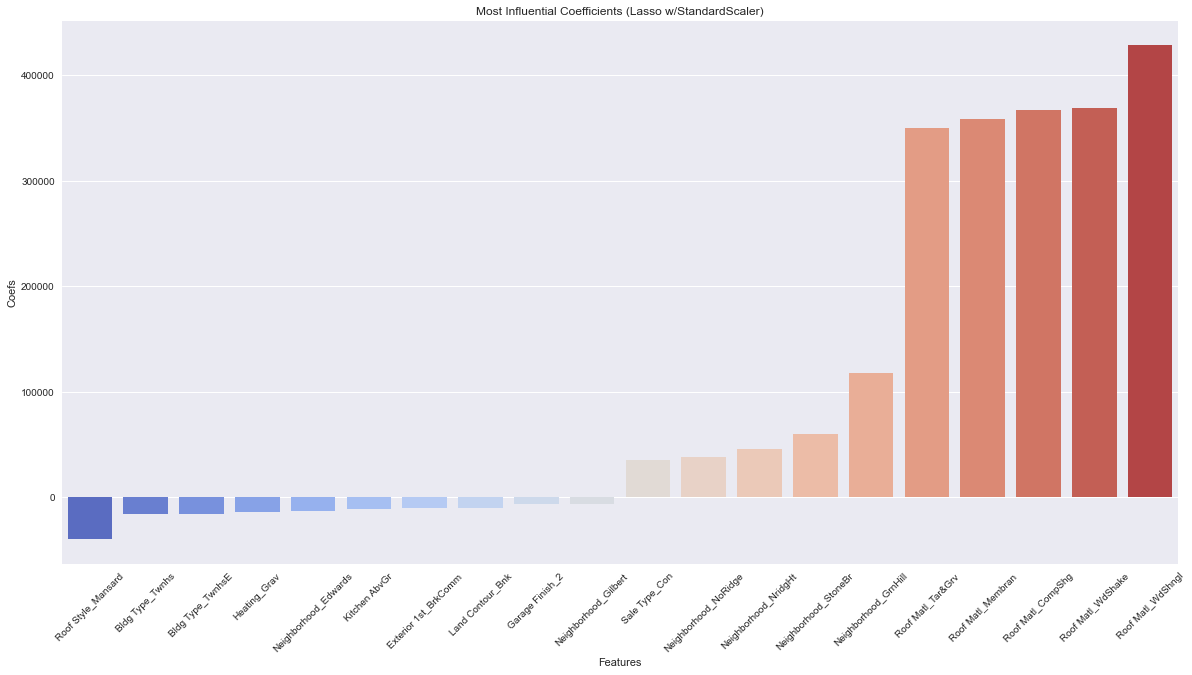

In [88]:
#plot coefs
lasso_largest = lasso_coefs.nlargest(10, 'Coefs')
lasso_smallest = lasso_coefs.nsmallest(10, 'Coefs')

lasso_largest_smallest = pd.concat([lasso_smallest, lasso_largest])

plt.style.use('seaborn')
plt.subplots(figsize=(20, 10))
sns.barplot(data = lasso_largest_smallest.sort_values('Coefs'), x='Features', y='Coefs', palette='coolwarm')
plt.title('Most Influential Coefficients (Lasso w/StandardScaler)')
plt.xticks(rotation=45);

In [89]:
lasso_largest_smallest.sort_values('Coefs', ascending=False)

,Features,Coefs
49,Roof Matl_WdShngl,428468.581905
48,Roof Matl_WdShake,369273.719812
45,Roof Matl_CompShg,366682.759278
46,Roof Matl_Membran,358750.287278
47,Roof Matl_Tar&Grv,350328.694648
16,Neighborhood_GrnHill,117845.579519
22,Neighborhood_StoneBr,59569.401294
20,Neighborhood_NridgHt,45965.388022
19,Neighborhood_NoRidge,38193.103117
101,Sale Type_Con,35028.778359


### Model #3 Summary

By utilizing a column transformer, a StandardScaler(), SelectKBest() and a Lasso(), we've managed to create a model through which 89.5% of the variance in SalePrice can be explained by the jumble of 150 variables (150 includes all the categorical variables that were OneHotEncoded - resulting in far more inputs that the original dataset's 80 some odd variables) that were chosen as the 'best'/most influential coefficients in building our model. It produced the lowest RMSE (25340.08) of all our models, an overall reduction of nearly 2/3 of our first model's RMSE.

I extracted the feature names and coefs and plotted just a small handful of them above (the highest/lowest 10). We can see here that this model identified several types of roofing material as being highly positively predictive of price, as well as several of the neighborhoods previously identified as having SalePrice distributions outside the mean/median. 

Interestingly, we the coefficients that represent positive relationships with `SalePrice` are much stronger than the 10 lowest negative coefficients. To me, this seems as though the the features and neighborhoods that are highly desirable are proportionally related to price, and the features that are negatively correlated represent slight 'dings' to the `SalePrice`, but don't totally crash the value of a home. 

Some of this is conjecture though, as this is a "Black Box" model. Overall, it is good for the Kaggle competition, but not for an end user who wants to derive actionable insights about specific house features or home locations that should result in a higher or lower sale price. 


This model could be improved by removing the outliers across a few key variables (namely Gr Liv Area and Lot Size). 

---


# Conclusion

Overall, we are able to get pretty good SalePrice predictions. Neighborhood is important (some more so than others), as is size and any features related to perceived the Quality/Appearance of the House. There is clearly some multicolinearity present in the data, which warrant further investigation if building an *accurate* and *interpretable* model is the ultimate goal. 